#Model financing products

### 0) Import libraries

In [ ]:
#pandas and numpy
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

from datetime import datetime

#plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

#machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, make_scorer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1) Data selection

#### 1.1) Load data

Load merged customer data
The merged df contains all columns except
*   the easyMoney++ account, which no customer has hired
*   the salary column, which turned out not to be a reliable feature during the analysis
* the country column, since the country is Spain in almost all cases    

No rows have been dropped from the original df.




In [ ]:
df = pd.read_csv("/content/drive/MyDrive/easyMoney_data/data/df_merged.csv")
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,pk,pk_cid_y,pk_partition_y,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,pk_cid,pk_partition,region_code,gender,age,deceased
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,13755862018-01-28,1375586,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1375586,2018-01-28,29.0,H,35,N
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506112018-01-28,1050611,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050611,2018-01-28,13.0,V,23,N
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,10506122018-01-28,1050612,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050612,2018-01-28,13.0,V,23,N
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,10506132018-01-28,1050613,2018-01-28,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,1050613,2018-01-28,50.0,H,22,N
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,10506142018-01-28,1050614,2018-01-28,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,1050614,2018-01-28,50.0,V,23,N


Drop columns that from the merge are not needed any longer (pk_cid_y, pk_partition_y, pk_cid, pk_partition pk)

In [ ]:
df.drop(columns=['pk_cid_y', 'pk_partition_y', 'pk', 'pk_cid', 'pk_partition'], inplace=True)
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,deceased
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,N
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,N
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,N
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22,N
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23,N


In [ ]:
df.shape

(5962924, 24)

#### 1.2) Data cleaning based on knowledge from analysis:

Remove
*   Deceased customers
*   Customers who are inactive and have never hired any products

In [ ]:
#drop rows with deceased customers
df = df[df['deceased']=='N']

In [ ]:
#drop 'deceased' column
df.drop(columns='deceased', inplace=True)

In [ ]:
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23


Remove pk_cid's for customers that have always been inactive and have never hired any products

In [ ]:
#sum up activity status and products hired
cols = ['active_customer','short_term_deposit',	'loans',
        'mortgage', 'funds',	'securities',	'long_term_deposit',	'credit_card',
        'payroll',	'pension_plan',	'payroll_account',	'emc_account',	'debit_card',	'em_account_p','em_acount']
df['products+activity'] = df[cols].sum(axis=1)
df.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,products+activity
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,2.0
1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,1.0
2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,13.0,V,23,1.0
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,50.0,H,22,1.0
4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,50.0,V,23,2.0


In [ ]:
#identify those customer IDs where the activity status and all products are always zero throughout the entire dataset
cust_ids_inactive = pd.DataFrame(df.groupby('pk_cid_x')['products+activity'].sum())
ids_to_drop = cust_ids_inactive[cust_ids_inactive['products+activity']==0].index

In [ ]:
ids_to_drop

Int64Index([  19812,   20303,   25482,   26303,   26557,   30317,   31507,
              34191,   35077,   36611,
            ...
            1553679, 1553680, 1553681, 1553683, 1553684, 1553685, 1553686,
            1553687, 1553688, 1553689],
           dtype='int64', name='pk_cid_x', length=102162)

In [ ]:
#create new df without these 'pk_cid_x'
df2 = df[~df['pk_cid_x'].isin(ids_to_drop)]

In [ ]:
df2.shape

(5036357, 24)

In [ ]:
#drop auxiliary column again
df2.drop(columns='products+activity', inplace=True)

<ipython-input-161-9d68dd015757>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns='products+activity', inplace=True)


### 2) Univariate analysis

#### 2.1) Check and impute datatypes if necessary

In [ ]:
df2.dtypes

pk_cid_x                int64
pk_partition_x         object
entry_date             object
entry_channel          object
active_customer       float64
segment                object
short_term_deposit      int64
loans                   int64
mortgage                int64
funds                   int64
securities              int64
long_term_deposit       int64
credit_card             int64
payroll               float64
pension_plan          float64
payroll_account         int64
emc_account             int64
debit_card              int64
em_account_p            int64
em_acount               int64
region_code           float64
gender                 object
age                     int64
dtype: object

The 'entry_date' and 'pk_partition_x' should be cast to a date format, the rest looks ok.

In [ ]:
#change format of 'pk_partition_x' to 'date'
df2['pk_partition_x'] = pd.to_datetime(df2['pk_partition_x'], format= '%Y-%m-%d')

#replace values for 02-29 in a non-leap year with 02-28
df2['entry_date'] = df2['entry_date'].replace(['2015-02-29'], '2015-02-28')
df2['entry_date'] = df2['entry_date'].replace(['2019-02-29'], '2019-02-28')

##change format of 'entry_date' to 'date'
df2['entry_date'] = pd.to_datetime(df2['entry_date'], format= '%Y-%m-%d')
df2.dtypes

<ipython-input-163-f7b97bd3db2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pk_partition_x'] = pd.to_datetime(df2['pk_partition_x'], format= '%Y-%m-%d')
<ipython-input-163-f7b97bd3db2b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['entry_date'] = df2['entry_date'].replace(['2015-02-29'], '2015-02-28')
<ipython-input-163-f7b97bd3db2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

pk_cid_x                       int64
pk_partition_x        datetime64[ns]
entry_date            datetime64[ns]
entry_channel                 object
active_customer              float64
segment                       object
short_term_deposit             int64
loans                          int64
mortgage                       int64
funds                          int64
securities                     int64
long_term_deposit              int64
credit_card                    int64
payroll                      float64
pension_plan                 float64
payroll_account                int64
emc_account                    int64
debit_card                     int64
em_account_p                   int64
em_acount                      int64
region_code                  float64
gender                        object
age                            int64
dtype: object

#### 2.2) Create target value column

If the customer has ever hired any of the financing products (debit card, credit card, loans), the target value is 1. If not, it is 0.

In [ ]:
#create column to check whether a customer has hired any of the financing products
df2['financing_products'] = df2[['debit_card','credit_card','loans']].sum(axis=1)
cond = df2['financing_products']>0
df2.loc[cond, 'financing_products']=1
df2['financing_products'].unique()

<ipython-input-164-8bd7b4734219>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['financing_products'] = df2[['debit_card','credit_card','loans']].sum(axis=1)


array([0, 1])

In [ ]:
#summarize this information by customer ID
sum_by_cust = pd.DataFrame(df2.groupby('pk_cid_x')['financing_products'].sum()).reset_index()
sum_by_cust.rename(columns={'financing_products': 'fin_prod_by_cust'}, inplace=True)
cond = sum_by_cust['fin_prod_by_cust'] >0
sum_by_cust['fin_prod_by_cust']= np.where(cond, 1, 0)
sum_by_cust['fin_prod_by_cust'].unique()

array([0, 1])

In [ ]:
sum_by_cust

,pk_cid_x,fin_prod_by_cust
0,15891,0
1,16063,0
2,16203,0
3,16502,0
4,17457,1
...,...,...
354151,1553541,0
354152,1553552,0
354153,1553559,0
354154,1553565,0


Target is merged with original df based on 'pk_cid_x'

In [ ]:
df3 = pd.merge(df2, sum_by_cust, on='pk_cid_x')
df3.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1
1,1375586,2018-02-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1
2,1375586,2018-03-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1
3,1375586,2018-04-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1
4,1375586,2018-05-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,H,35,1,1


#### 2.3) Descriptive statistics of continuous variable (age)

In [ ]:
df3[['age']].describe().round(2)

,age
count,5036357.00
mean,29.70
std,11.88
min,2.00
25%,22.00
50%,25.00
75%,34.00
max,105.00


As can be seen with the describe method the age column contains many entries from young people since the median value is 25. The minimum value of 2 and the maximum value of 105 imply a normal age distribution.

#### 2.4) Detection and imputation of null values

In [ ]:
df3.isna().sum()

pk_cid_x                  0
pk_partition_x            0
entry_date                0
entry_channel         95708
active_customer           0
segment               96476
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                  56
pension_plan             56
payroll_account           0
emc_account               0
debit_card                0
em_account_p              0
em_acount                 0
region_code            1865
gender                   25
age                       0
financing_products        0
fin_prod_by_cust          0
dtype: int64

Several columns contain null-values ('entry_channel', 'segment', 'payroll', 'pension_plan', 'region code', 'gender').
Only the ones in the 'pension_plan' and 'payroll' columns will be replaced with 0 since the other columns are categorical and will be OneHotEncoded anyways.

In [ ]:
df3['payroll'].fillna(0, inplace=True)
df3['pension_plan'].fillna(0, inplace=True)

In [ ]:
df3.isna().sum()

pk_cid_x                  0
pk_partition_x            0
entry_date                0
entry_channel         95708
active_customer           0
segment               96476
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                   0
pension_plan              0
payroll_account           0
emc_account               0
debit_card                0
em_account_p              0
em_acount                 0
region_code            1865
gender                   25
age                       0
financing_products        0
fin_prod_by_cust          0
dtype: int64

#### 2.5) Unique values per column

In [ ]:
df3.nunique()

pk_cid_x              354156
pk_partition_x            17
entry_date              1469
entry_channel             60
active_customer            2
segment                    3
short_term_deposit         2
loans                      2
mortgage                   2
funds                      2
securities                 2
long_term_deposit          2
credit_card                2
payroll                    2
pension_plan               2
payroll_account            2
emc_account                2
debit_card                 2
em_account_p               2
em_acount                  2
region_code               52
gender                     2
age                      104
financing_products         2
fin_prod_by_cust           2
dtype: int64

#### 2.6) Detection of outliers

In [ ]:
outlier_testing_col = ['age']

In [ ]:
#define outliers based on quantiles
def univariate_outliers(s):
    """
    Input: series S
    Output: series with numerical values
    * 2: extreme high outlier
    * 1: moderate high outlier/suspected outlier
    * -1: moderate low outlier/suspected outlier
    * -2: extreme low outlier
    """
    q1 = s.quantile(q=0.25)
    q3 = s.quantile(q=0.75)
    iqr = q3 - q1
    out = (
        (s > (q3 + 1.5 * iqr)).astype(int)
        + (s > (q3 + 3 * iqr)).astype(int)
        - (s < (q1 - 1.5 * iqr)).astype(int)
        - (s < (q1 - 3 * iqr)).astype(int)
    )
    return out

In [ ]:
outl_df = pd.DataFrame(
    {
        "outl_" + col: univariate_outliers(df3[col])
        for col in outlier_testing_col
    }
)

In [ ]:
outl_df.melt().reset_index().pivot_table(
    index="variable",
    columns="value",
    values="index",
    aggfunc="count",
    fill_value=0
)

value,-1,0,1,2
variable,,,,
outl_age,2039,4722089,249249,62980


There seem to besome outliers in the 'age' column, but as this column seems to have a normal distribution overall no action will be taken on those.

#### 2.7) Visualizations

Visualize target variable

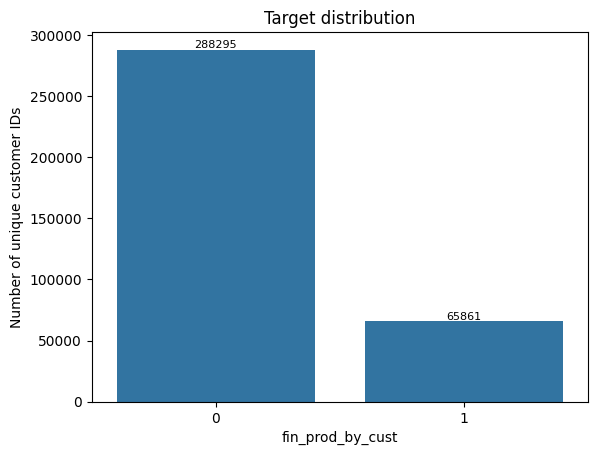

In [ ]:
df_new = df3.groupby('fin_prod_by_cust')['pk_cid_x'].nunique().reset_index()
ax = sns.barplot(data=df_new, x='fin_prod_by_cust', y ='pk_cid_x')
plt.ylabel("Number of unique customer IDs")
plt.title("Target distribution")
for i in ax.containers:
    ax.bar_label(i,size=8)

Throughout the dataset there are 65861 unique customer IDs that have hired one of the financing products, and 288295 that have not.

Before visualizing each variable against the target:


*   As the entry channel distribution seems to be quite imbalanced the entry channels that are not in the top10 will be renamed "entry channel others".
*   Same applies to the region code
*   As the entry date column has a high number of unique values only the "month" and "year" will be extracted



In [ ]:
#identify top10 entry channels
df_new = df3.groupby('entry_channel')['pk_cid_x'].nunique().reset_index()
df_new.sort_values(by='pk_cid_x', ascending=False, inplace=True)
top10 = df_new['entry_channel'].head(10).tolist()

#create new column to specify whether a customer belongs to the top10 entry channels or not
cond = ~df3['entry_channel'].isin(top10)
df3['entry_channel_'] = np.where(cond, "entry_channel_others", df3['entry_channel'])
df3['entry_channel_'].unique()

array(['entry_channel_others', 'KHE', 'KHD', 'KFA', 'KFC', 'KAT', 'RED',
       'KHQ', 'KHK', 'KHM', 'KHN'], dtype=object)

In [ ]:
#identify top5 region codes
df_new = df3.groupby('region_code')['pk_cid_x'].nunique().reset_index()
df_new.sort_values(by='pk_cid_x', ascending=False, inplace=True)
top10 = df_new['region_code'].head(10).tolist()

#create new column to specify whether a customer belongs to the top10 region codes or not
cond = ~df3['region_code'].isin(top10)
df3['region_code_'] = np.where(cond, "region_code_others", df3['region_code'])
df3['region_code_'].unique()

array(['29.0', 'region_code_others', '8.0', '28.0', '3.0', '41.0', '36.0',
       '46.0', '15.0', '30.0', '11.0'], dtype=object)

In [ ]:
#extract month from 'entry_date' column
df3['entry_month'] = df3['entry_date'].dt.strftime('%B')
df3['entry_month'].unique()

array(['January', 'August', 'October', 'July', 'December', 'September',
       'March', 'April', 'February', 'November', 'May', 'June'],
      dtype=object)

In [ ]:
#extract year from 'entry_date' column
df3['entry_year'] = df3['entry_date'].dt.year
df3['entry_year'].unique()

array([2018, 2015, 2017, 2016, 2019])

In [ ]:
#create df filtered by financing_products==1
df4 = df3[df3['fin_prod_by_cust']==1]
df4.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,entry_channel_,region_code_,entry_month,entry_year
0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1,entry_channel_others,29.0,January,2018
1,1375586,2018-02-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1,entry_channel_others,29.0,January,2018
2,1375586,2018-03-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1,entry_channel_others,29.0,January,2018
3,1375586,2018-04-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,29.0,H,35,0,1,entry_channel_others,29.0,January,2018
4,1375586,2018-05-28,2018-01-12,KHL,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,29.0,H,35,1,1,entry_channel_others,29.0,January,2018


Entry Channel

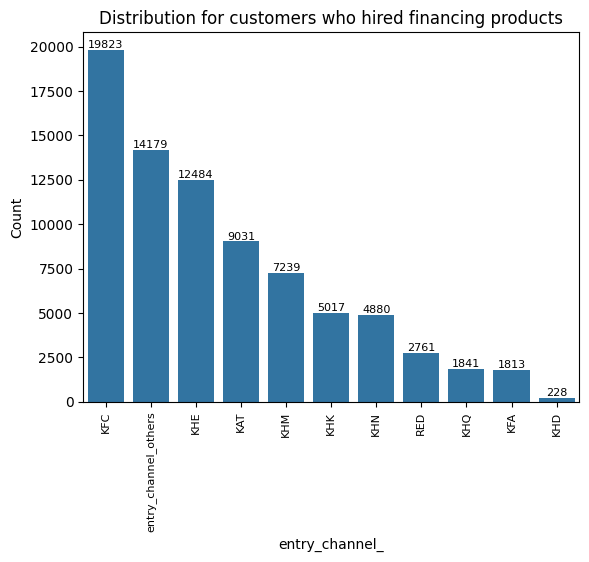

In [ ]:
#visualize entry_channel distribution
df_new = df4.groupby('entry_channel_')['pk_cid_x'].nunique().reset_index()
df_new.sort_values(by='pk_cid_x', ascending=False, inplace=True)
ax = sns.barplot(data=df_new, x='entry_channel_', y ='pk_cid_x')
ax.set_ylabel("Count")
ax.set(title='Distribution for customers who hired financing products')
plt.xticks(rotation=90, size=8)
for i in ax.containers:
  ax.bar_label(i,size=8)

'KFC' is the most popular entry channel among customers who have hired financing products.

Region code

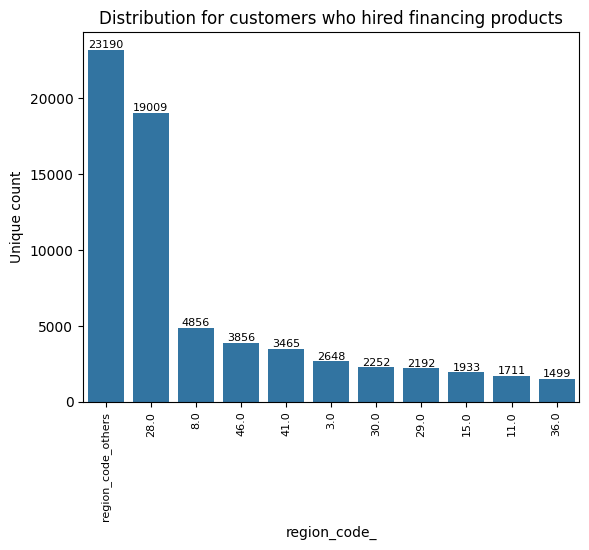

In [ ]:
#visualize region_code distribution for customers who hired financing products
df_new = df4.groupby('region_code_')['pk_cid_x'].nunique().reset_index()
df_new.sort_values(by='pk_cid_x', ascending=False, inplace=True)
ax = sns.barplot(data=df_new, x='region_code_', y ='pk_cid_x')
ax.set_ylabel("Unique count")
ax.set(title='Distribution for customers who hired financing products')
plt.xticks(rotation=90, size=8)
for i in ax.containers:
  ax.bar_label(i,size=8)

Out of the customers who have hired financing products around 19,000 are from the top region code in the dataset, the rest of the customers are from other regions.

Entry month

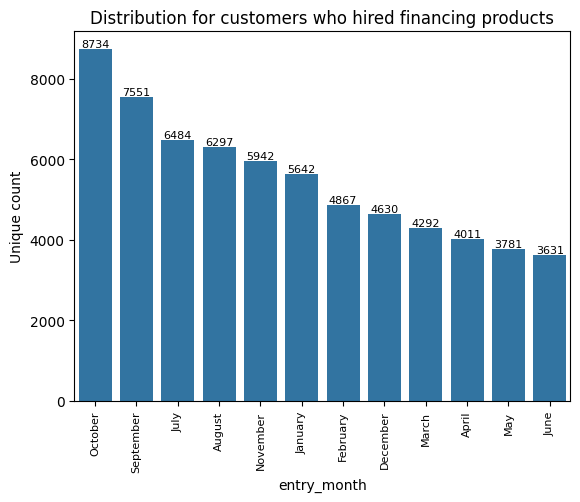

In [ ]:
df_new = df4.groupby('entry_month')['pk_cid_x'].nunique().reset_index()
df_new.sort_values(by='pk_cid_x', ascending=False, inplace=True)
ax = sns.barplot(data=df_new, x='entry_month', y ='pk_cid_x')
ax.set_ylabel("Unique count")
ax.set(title='Distribution for customers who hired financing products')
plt.xticks(rotation=90, size=8)
for i in ax.containers:
  ax.bar_label(i,size=8)

For the customers who have hired financing products it seems to be most common to have signed up in September or October.

Entry year

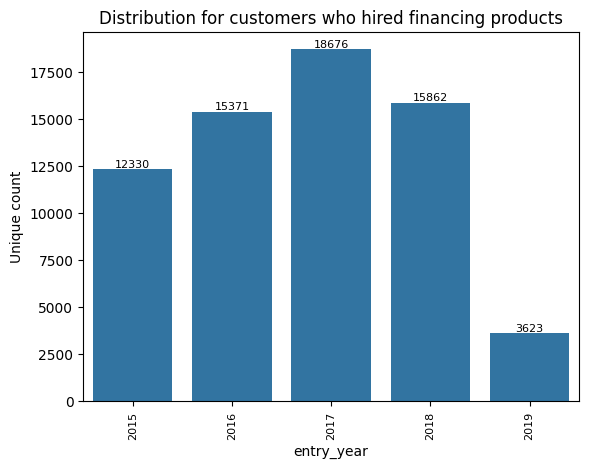

In [ ]:
df_new = df4.groupby('entry_year')['pk_cid_x'].nunique().reset_index()
ax = sns.barplot(data=df_new, x='entry_year', y ='pk_cid_x')
ax.set_ylabel("Unique count")
ax.set(title='Distribution for customers who hired financing products')
plt.xticks(rotation=90, size=8)
for i in ax.containers:
  ax.bar_label(i,size=8)

Most of the customers who have hired financing products have first signed up in 2017.

Create functions to visualize remaining distributions against target variable

In [ ]:
def vis_features(colname,df=df):
    df_new = df4.groupby(colname)['pk_cid_x'].nunique().reset_index()
    ax = sns.barplot(data=df_new, x=colname, y ='pk_cid_x')
    ax.set_ylabel("Unique count")
    ax.set(title='Distribution for customers who hired financing products')
    plt.xticks(size=8)
    for i in ax.containers:
      ax.bar_label(i,size=8)
    return ax

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='active_customer', ylabel='Unique count'>

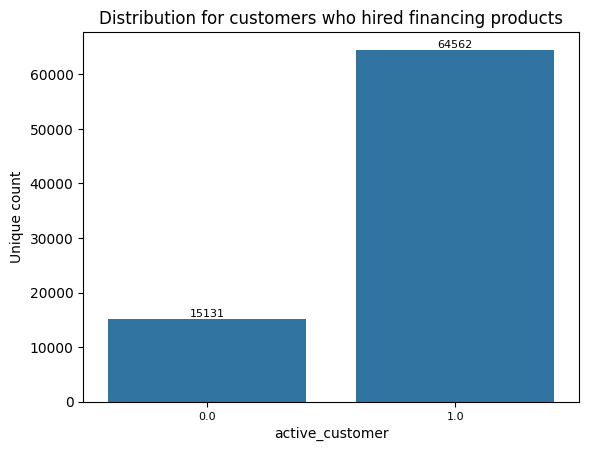

In [ ]:
vis_features('active_customer')

Most of the customers who have hired financing products are active.

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='segment', ylabel='Unique count'>

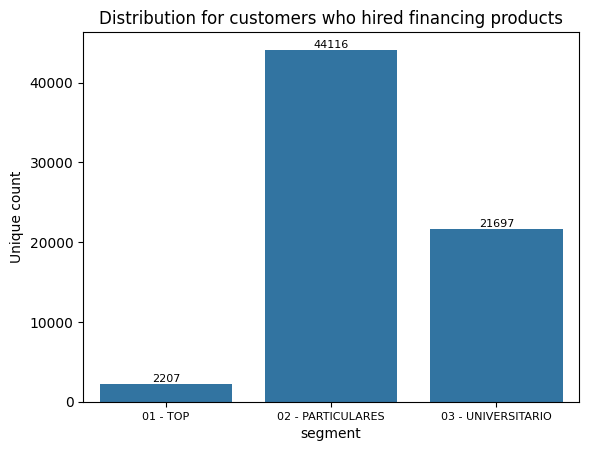

In [ ]:
vis_features('segment')

Most of the customers who have hired financing products belong to the segment '02-PARTICULARES', followed by '03-UNIVERSITARIO'.

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='short_term_deposit', ylabel='Unique count'>

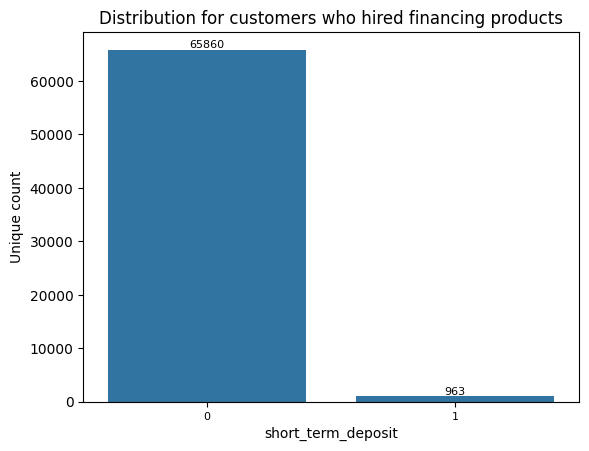

In [ ]:
vis_features('short_term_deposit')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='loans', ylabel='Unique count'>

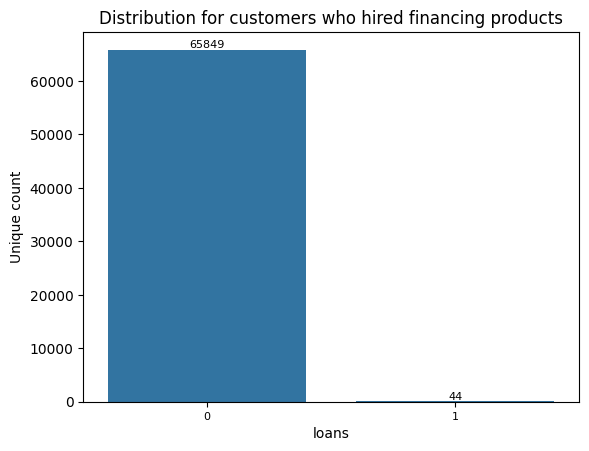

In [ ]:
vis_features('loans')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='mortgage', ylabel='Unique count'>

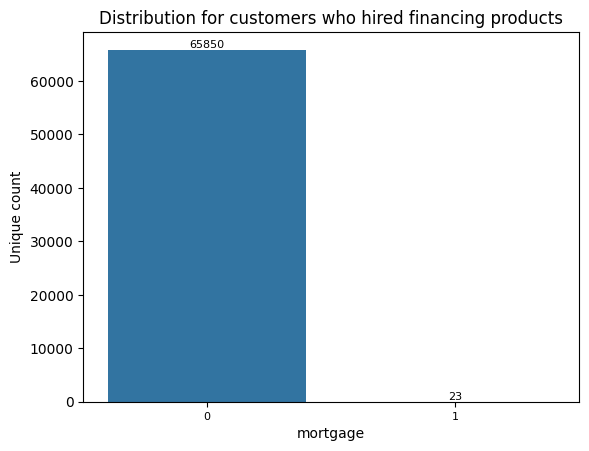

In [ ]:
vis_features('mortgage')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='funds', ylabel='Unique count'>

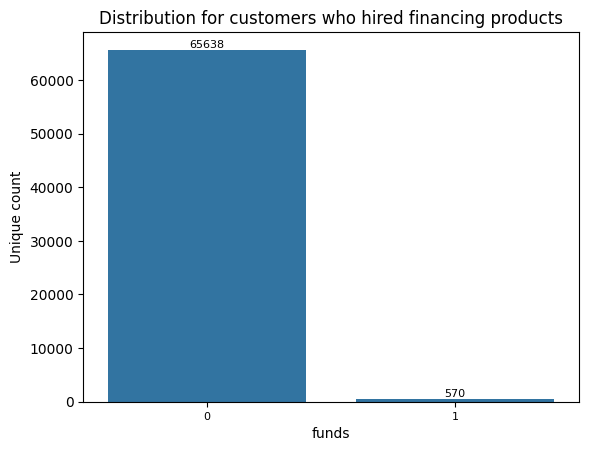

In [ ]:
vis_features('funds')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='credit_card', ylabel='Unique count'>

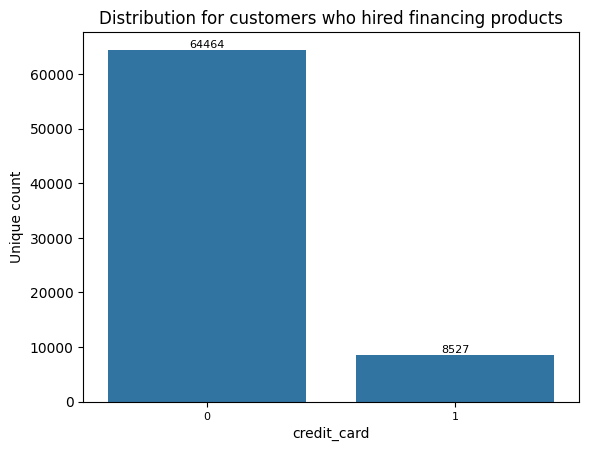

In [ ]:
vis_features('credit_card')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='payroll', ylabel='Unique count'>

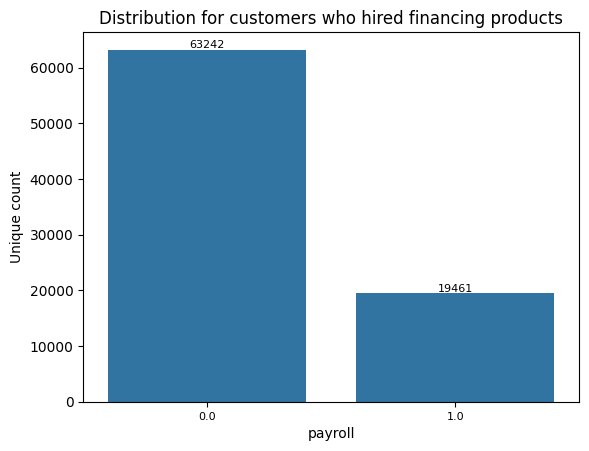

In [ ]:
vis_features('payroll')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='pension_plan', ylabel='Unique count'>

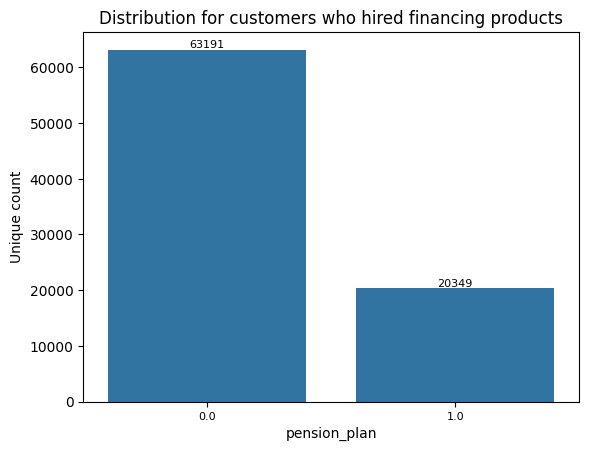

In [ ]:
vis_features('pension_plan')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='payroll_account', ylabel='Unique count'>

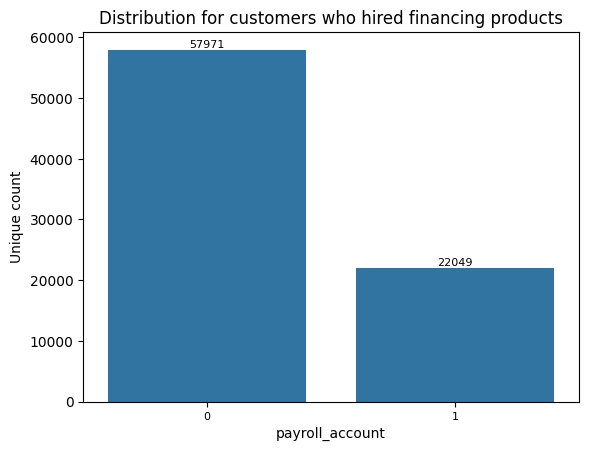

In [ ]:
vis_features('payroll_account')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='emc_account', ylabel='Unique count'>

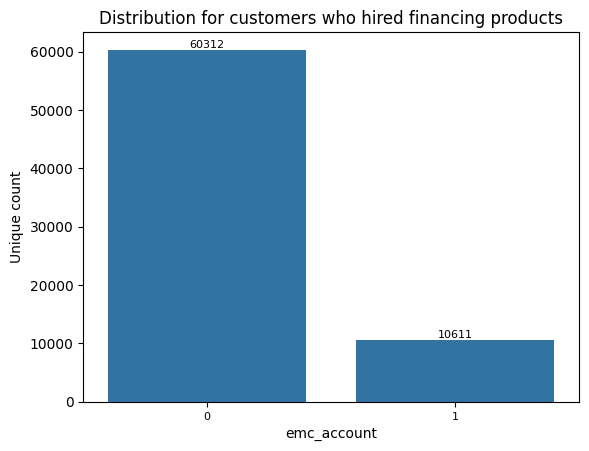

In [ ]:
vis_features('emc_account')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='debit_card', ylabel='Unique count'>

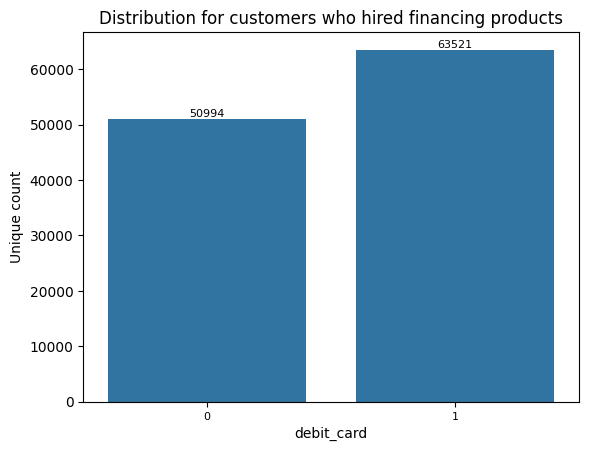

In [ ]:
vis_features('debit_card')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='em_account_p', ylabel='Unique count'>

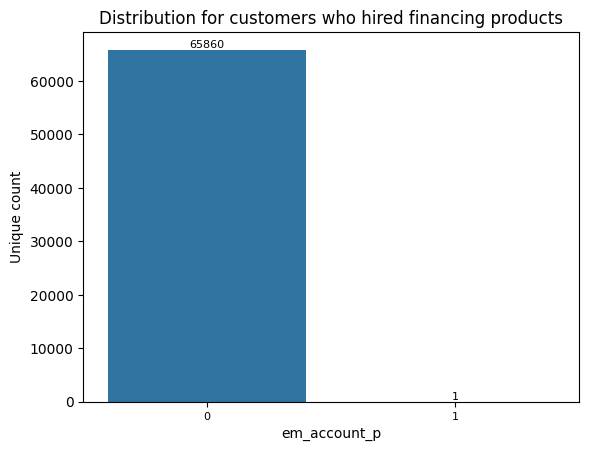

In [ ]:
vis_features('em_account_p')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='em_acount', ylabel='Unique count'>

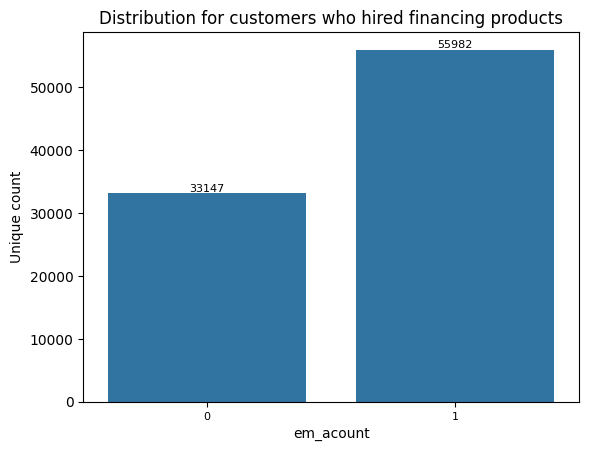

In [ ]:
vis_features('em_acount')

<Axes: title={'center': 'Distribution for customers who hired financing products'}, xlabel='gender', ylabel='Unique count'>

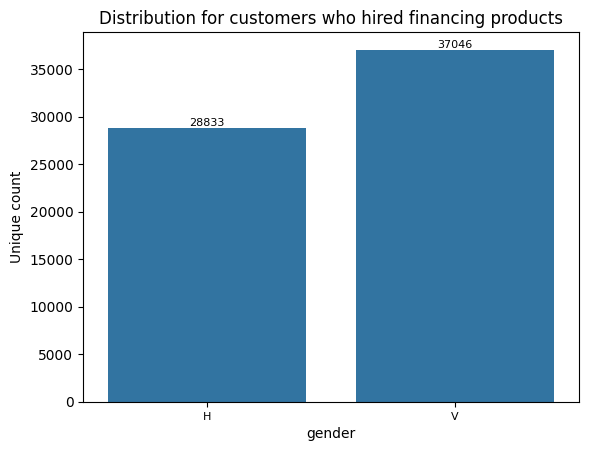

In [ ]:
vis_features('gender')

There are slightly more men than women among those customers that have hired financing products.

([<matplotlib.axis.XTick at 0x7eadf63b7040>,
 [Text(0, 0, '2'),
  Text(5, 0, '23'),
  Text(10, 0, '28'),
  Text(15, 0, '33'),
  Text(20, 0, '38'),
  Text(25, 0, '43'),
  Text(30, 0, '48'),
  Text(35, 0, '53'),
  Text(40, 0, '58'),
  Text(45, 0, '63'),
  Text(50, 0, '68'),
  Text(55, 0, '73'),
  Text(60, 0, '78'),
  Text(65, 0, '83'),
  Text(70, 0, '88'),
  Text(75, 0, '93'),
  Text(80, 0, '98')])

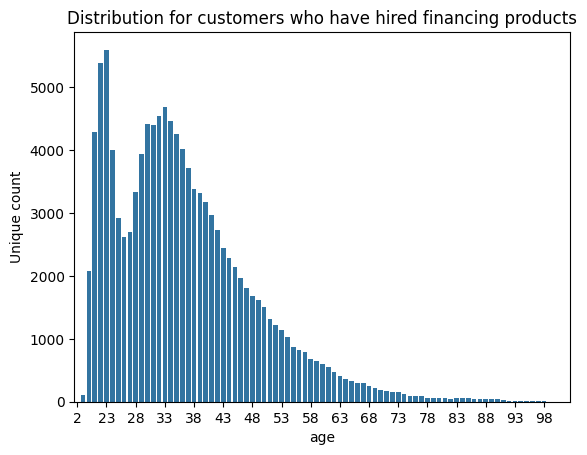

In [ ]:
df_new = df4.groupby('age')['pk_cid_x'].nunique().reset_index()
sns.barplot(data=df_new, x='age', y='pk_cid_x')
plt.title('Distribution for customers who have hired financing products')
plt.ylabel("Unique count")
plt.xticks(range(0, len(df_new['age']), 5))

The age distribution for customers who have hired financing products is skewed to the left, with a peak around 24 years, then a drop and another peak at around 34 years.

### 3) Data preparation

#### 3.1) Row selection

The goal of this model is to predict the likelihood of someone hiring one of the financing products.
For customers who have hired financing products at some point, we need to select only those rows before the 'financing products' column switched from 0 to 1 because the goal of this model is to figure out the characteristics of our customers before they hired those products.

To drop the rows from the dataset where 'financing_products' switches from 0 to 1 and below for each customer ID the df needs to be sorted by 'pk_cid' and 'pk_partition' and the index reset.

In [ ]:
df3.sort_values(by=['pk_cid_x','pk_partition_x'], inplace=True)

In [ ]:
df3.reset_index()

,index,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,entry_channel_,region_code_,entry_month,entry_year
0,4249146,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,28.0,H,59,0,0,KAT,28.0,July,2018
1,4249147,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,59,0,0,KAT,28.0,July,2018
2,4879501,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018
3,4879502,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018
4,4879503,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036352,5035635,1553541,2019-05-28,2019-05-31,NaN,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,49.0,V,54,0,0,entry_channel_others,region_code_others,May,2019
5036353,5035643,1553552,2019-05-28,2019-05-31,NaN,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,35,0,0,entry_channel_others,28.0,May,2019
5036354,5035642,1553559,2019-05-28,2019-05-31,NaN,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,8.0,H,43,0,0,entry_channel_others,8.0,May,2019
5036355,5035641,1553565,2019-05-28,2019-05-31,NaN,0.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,45.0,H,68,0,0,entry_channel_others,region_code_others,May,2019


The 'pk' is created as a combination of 'pk_cid_x' and pk_partition_x' to identify the rows that need to be dropped.

In [ ]:
df3['pk']=df3['pk_cid_x'].astype(str)+df3['pk_partition_x'].astype(str)
df3.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,entry_channel_,region_code_,entry_month,entry_year,pk
4249146,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,28.0,H,59,0,0,KAT,28.0,July,2018,158912018-07-28
4249147,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,59,0,0,KAT,28.0,July,2018,158912018-08-28
4879501,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632018-11-28
4879502,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632018-12-28
4879503,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632019-01-28


Find rows that need to be dropped based on values in 'pk' column

In [ ]:
# Find the customer IDs with a switch from 0 to 1
switch_customer_ids = df3[df3['financing_products'].diff() == 1]['pk_cid_x'].unique()

# Initialize an empty list to store values in 'pk' to drop
pk_values_to_drop = []

# Iterate over the identified customer IDs
for pk_cid_x in switch_customer_ids:
    # Filter the DataFrame for the current customer ID
    group_df = df3[df3['pk_cid_x'] == pk_cid_x]
    # Find the index of the first switch from 0 to 1 within the group
    switch_index = group_df.index[group_df['financing_products'].diff() == 1].min()
    # Append values in 'pk' to drop (including the switch value)
    pk_values_to_drop.extend(group_df.loc[group_df.index >= switch_index, 'pk'])

# Print values in 'pk' to drop
print("Values in 'pk' to drop:")
print(pk_values_to_drop)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
len(pk_values_to_drop)

412389

412389 rows need to be dropped from the df. An example will be checked to see if rows have been identified correctly.

In [ ]:
#check first example to drop
pk_values_to_drop[0]

'174572018-09-28'

In [ ]:
#filter original df by 'pk_cid_x' == 17457
df3[df3['pk_cid_x']==17457]

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,entry_channel_,region_code_,entry_month,entry_year,pk
4001073,17457,2018-01-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-01-28
4001074,17457,2018-02-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-02-28
4001075,17457,2018-03-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-03-28
4001076,17457,2018-04-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-04-28
4001077,17457,2018-05-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-05-28
4001078,17457,2018-06-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-06-28
4001079,17457,2018-07-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-07-28
4001080,17457,2018-08-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-08-28
4001081,17457,2018-09-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,1,0,0.0,0.0,0,0,1,0,1,28.0,H,53,1,1,KAT,28.0,September,2017,174572018-09-28
4001082,17457,2018-10-28,2017-09-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,28.0,H,53,0,1,KAT,28.0,September,2017,174572018-10-28


In [ ]:
#filter out all pk values that need to be dropped for customer ID 17457
def filter_numbers_by_starting_digits(numbers, starting_digits):
    filtered_numbers = [num for num in numbers if any(str(num).startswith(digit) for digit in starting_digits)]
    return filtered_numbers

digits_to_include = ['17457']
filtered_numbers = filter_numbers_by_starting_digits(pk_values_to_drop, digits_to_include)
print(filtered_numbers)

['174572018-09-28', '174572018-10-28', '174572018-11-28', '174572018-12-28', '174572019-01-28', '174572019-02-28', '174572019-03-28', '174572019-04-28', '174572019-05-28']


In [ ]:
len(filtered_numbers)

9

Pk values to drop were identified correctly as shown in the example. As can be seen in the df the 'financing_products' value for 'pk_cid_x' 17457 first switches from 0 to 1 on 'pk_partition_x' = 2018-09-28. The last 'pk_partition' to drop is 2019-05-28, and a total number of 9 rows need to be dropped.

In [ ]:
print("shape before drop:",df3.shape)

shape before drop: (5036357, 30)


In [ ]:
df5 = df3[~df3['pk'].isin(pk_values_to_drop)]
print("shape after drop:",df5.shape)

shape after drop: (4623968, 30)


In [ ]:
df5.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,entry_channel_,region_code_,entry_month,entry_year,pk
4249146,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,28.0,H,59,0,0,KAT,28.0,July,2018,158912018-07-28
4249147,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,59,0,0,KAT,28.0,July,2018,158912018-08-28
4879501,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632018-11-28
4879502,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632018-12-28
4879503,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,KAT,28.0,November,2018,160632019-01-28


#### 3.2) Encoding

Columns to be OneHotEncoded encoded
*   Entry channel (Only top10)
*   Segment
*   Region code (Only top1)
*   Gender
*   Entry month
*   Entry year




In [ ]:
#get dummies and concatenate values with df
ohe_ec = pd.get_dummies(df5['entry_channel_'])
ohe_reg = pd.get_dummies(df5['region_code_'])
ohe_seg = pd.get_dummies(df5['segment'])
ohe_gen = pd.get_dummies(df5['gender'])
ohe_em = pd.get_dummies(df5['entry_month'])
ohe_ey = pd.get_dummies(df5['entry_year'])

df6 = pd.concat([df5, ohe_ec, ohe_reg, ohe_seg, ohe_gen, ohe_em, ohe_ey], axis=1)
df6.head()

,pk_cid_x,pk_partition_x,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,region_code,gender,age,financing_products,fin_prod_by_cust,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
4249146,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,28.0,H,59,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4249147,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,59,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4879501,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4879502,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4879503,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,28.0,H,62,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### 3.4) Drop encoded columns and columns directly related to the target

In [ ]:
df6.columns

Index([            'pk_cid_x',       'pk_partition_x',           'entry_date',
              'entry_channel',      'active_customer',              'segment',
         'short_term_deposit',                'loans',             'mortgage',
                      'funds',           'securities',    'long_term_deposit',
                'credit_card',              'payroll',         'pension_plan',
            'payroll_account',          'emc_account',           'debit_card',
               'em_account_p',            'em_acount',          'region_code',
                     'gender',                  'age',   'financing_products',
           'fin_prod_by_cust',       'entry_channel_',         'region_code_',
                'entry_month',           'entry_year',                   'pk',
                        'KAT',                  'KFA',                  'KFC',
                        'KHD',                  'KHE',                  'KHK',
                        'KHM',                  'KHN

In [ ]:
df7=df6.drop(columns=['entry_date','entry_channel','region_code', 'region_code_',
                      'segment','gender','entry_month','entry_year','entry_channel_','pk', 'financing_products','debit_card','credit_card','loans'])

In [ ]:
df7.columns

Index([            'pk_cid_x',       'pk_partition_x',      'active_customer',
         'short_term_deposit',             'mortgage',                'funds',
                 'securities',    'long_term_deposit',              'payroll',
               'pension_plan',      'payroll_account',          'emc_account',
               'em_account_p',            'em_acount',                  'age',
           'fin_prod_by_cust',                  'KAT',                  'KFA',
                        'KFC',                  'KHD',                  'KHE',
                        'KHK',                  'KHM',                  'KHN',
                        'KHQ',                  'RED', 'entry_channel_others',
                       '11.0',                 '15.0',                 '28.0',
                       '29.0',                  '3.0',                 '30.0',
                       '36.0',                 '41.0',                 '46.0',
                        '8.0',   'region_code_others

In [ ]:
df7.columns = df7.columns.astype(str)

In [ ]:
df7.head()

,pk_cid_x,pk_partition_x,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,fin_prod_by_cust,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
4249146,15891,2018-07-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,59,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4249147,15891,2018-08-28,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,59,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4879501,16063,2018-11-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4879502,16063,2018-12-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4879503,16063,2019-01-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### 3.5) Feature correlations

In [ ]:
df_cor = df7.corr()
df_cor_target = df_cor['fin_prod_by_cust'].reset_index()

<ipython-input-222-220ee69bac71>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cor = df7.corr()


In [ ]:
df_cor_target.sort_values(by='fin_prod_by_cust')

,index,fin_prod_by_cust
39,03 - UNIVERSITARIO,-0.297968
19,KHE,-0.276205
12,em_acount,-0.252201
23,KHQ,-0.109747
0,pk_cid_x,-0.072472
...,...,...
7,payroll,0.345579
8,pension_plan,0.353787
1,active_customer,0.357062
9,payroll_account,0.395276


The feature correlations show that someone is more likely to hire financing products if they are classified as an active customer or have been awarded with a bonus due to payroll, for example. High negative correlations with the target are the segment "03-UNIVERSITARIO" or entry channel "KHE".

### 4) Model building

#### 4.1) Train/test split

For the train/test split the temporal component of the dataset needs to be taken into account, so the dataframe is sorted by 'pk_partition'. But most importantly, we need to make sure that those customer IDs that the model has already been trained on do not appear again in the other sets (data leakage), which is why the dataset is also sorted by 'pk_cid_x'

In [ ]:
df7.sort_values(by=['pk_cid_x','pk_partition_x'], inplace=True)

In [ ]:
df7.reset_index(inplace=True)

In [ ]:
#drop old index column
df7.drop(columns='index', inplace=True)

In [ ]:
df7.head()

,pk_cid_x,pk_partition_x,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,fin_prod_by_cust,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
0,15891,2018-07-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,59,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,15891,2018-08-28,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,59,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,16063,2018-11-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,16063,2018-12-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,16063,2019-01-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


Later this dataframe, df7, will be used to identify the 'pk_cid_x' of the customers that are supposed to receive the email.

In [ ]:
#drop 'pk_partition_x' and 'pk_cid_x'
df8 = df7.drop(columns =['pk_cid_x','pk_partition_x'])

In [ ]:
df8.head()

,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,fin_prod_by_cust,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,RED,entry_channel_others,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
0,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,59,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,59,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1.0,0,0,0,0,0,0.0,0.0,0,0,0,0,62,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


The first entries in the dataset are used as a training set, followed by the validation set to optimize hyperparameters and the test set to check the test accuracy. The last 50% of the data is used as the selection set, the email recipients are selected from here.

In [ ]:
size_train = int(df8.shape[0]*0.30)
print("size training set:",size_train)

size training set: 1387190


In [ ]:
size_val = int(df8.shape[0]*0.10)
print("size validation set:",size_val)

size validation set: 462396


In [ ]:
size_test=int(df8.shape[0]*0.10)
print("size test set:",size_test)

size test set: 462396


In [ ]:
size_sel = int(df8.shape[0]*0.50)
print("size selection set:", size_sel)

size selection set: 2311984


Perform train/test split

In [ ]:
# Define the row indices for the splits
train_end_index = size_train
validation_end_index = train_end_index + size_val
test_end_index = validation_end_index + size_test

# Split the dataset into train, validation, and test sets
train_set = df8[:train_end_index]
validation_set = df8[train_end_index:validation_end_index]
test_set = df8[validation_end_index:test_end_index ]
sel_set = df8[test_end_index :]

# Split each set into X and Y
train_X = train_set.drop(columns=['fin_prod_by_cust'])
train_y = train_set['fin_prod_by_cust']

val_X = validation_set.drop(columns=['fin_prod_by_cust'])
val_y = validation_set['fin_prod_by_cust']

test_X = test_set.drop(columns=['fin_prod_by_cust'])
test_y = test_set['fin_prod_by_cust']

# Check the shapes of X and Y for each set
print("Train X shape:", train_X.shape, "Train Y shape:", train_y.shape)
print("Validation X shape:", val_X.shape, "Validation Y shape:", val_y.shape)
print("Test X shape:", test_X.shape, "Test Y shape:", test_y.shape)
print("Selection set shape:", sel_set.shape)

Train X shape: (1387190, 57) Train Y shape: (1387190,)
Validation X shape: (462396, 57) Validation Y shape: (462396,)
Test X shape: (462396, 57) Test Y shape: (462396,)
Selection set shape: (2311986, 58)


#### 4.2) Scaling

In [ ]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training set's 'age' column and transform it
train_X_scaled = train_X.copy()
train_X_scaled['age'] = scaler.fit_transform(train_X_scaled[['age']])

# Transform 'age' column in validation, test and selection sets using the scaler fitted on training set
val_X_scaled = val_X.copy()
val_X_scaled['age'] = scaler.transform(val_X_scaled[['age']])

test_X_scaled = test_X.copy()
test_X_scaled['age'] = scaler.transform(test_X_scaled[['age']])

sel_set['age'] = scaler.transform(sel_set[['age']])

# Check the scaled 'age' column in the datasets
print("Scaled Train X:")
print(train_X_scaled.head())

print("\nScaled Validation X:")
print(val_X_scaled.head())

print("\nScaled Test X:")
print(test_X_scaled.head())

print("\nScaled Selection set:")
print(sel_set.head())

Scaled Train X:
   active_customer  short_term_deposit  mortgage  funds  securities  \
0              1.0                   0         0      0           0   
1              0.0                   0         0      0           0   
2              1.0                   0         0      0           0   
3              1.0                   0         0      0           0   
4              1.0                   0         0      0           0   

   long_term_deposit  payroll  pension_plan  payroll_account  emc_account  \
0                  0      0.0           0.0                0            0   
1                  0      0.0           0.0                0            0   
2                  0      0.0           0.0                0            0   
3                  0      0.0           0.0                0            0   
4                  0      0.0           0.0                0            0   

   em_account_p  em_acount   age  KAT  KFA  KFC  KHD  KHE  KHK  KHM  KHN  KHQ  \
0            

<ipython-input-235-7b12214247de>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_set['age'] = scaler.transform(sel_set[['age']])


#### 4.3) Modeling

##### 4.3.1) Decision Tree

a) Model building

The maximum depth of the tree is set to 5 to prevent overfitting.

In [ ]:
#instantiate the DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

#train the model
tree_model.fit(train_X_scaled, train_y )

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
#get importances
importances_tree = tree_model.feature_importances_

#save them to a df
feature_importances_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': importances_tree
})

# Sort the DataFrame by importance score (if needed)
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importances_df.head()

,Feature,Importance
8,payroll_account,0.620519
0,active_customer,0.228684
12,age,0.109402
17,KHE,0.018568
9,emc_account,0.009358


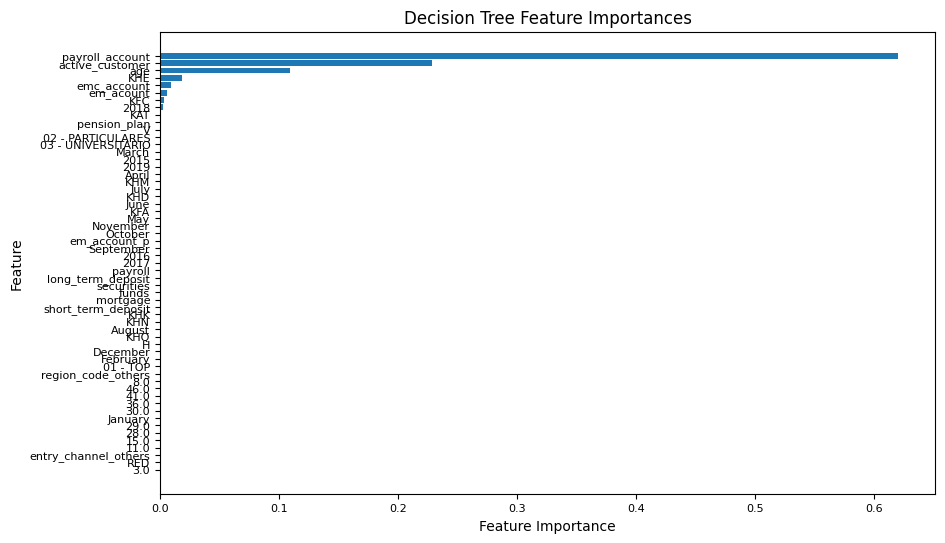

In [ ]:
# Sort feature importances
sorted_indices = importances_tree.argsort()
sorted_features = train_X.columns[sorted_indices]
sorted_importances = importances_tree[sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

b) Predictions

In [ ]:
#define function for results df creation
def results_eval(mod, x_train, y_train_):
    y_train_df = pd.DataFrame(y_train_)
    y_train_pred = pd.DataFrame(mod.predict(x_train), index=y_train_.index, columns=['fin_prod_prediction'])
    results_df = y_train_df.join(y_train_pred, how= 'inner')
    results_df['Success'] = (results_df['fin_prod_by_cust'] == results_df['fin_prod_prediction']).astype(int)
    return results_df

In [ ]:
results_tree = results_eval(tree_model,train_X_scaled, train_y)
results_tree

,fin_prod_by_cust,fin_prod_prediction,Success
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1387185,1,0,0
1387186,1,0,0
1387187,1,0,0
1387188,1,0,0


c) Evaluation

When evaluating the model special attention needs to be paid to the F1 score because it is important to have a low false positive rate to not waste resources (high Precision) and to also identify the true positives (high Recall). The F1 score combines both metrics, that is why special attention will be paid to this.

In [ ]:
#define function to show metrics
def metr(results_df, mod, X_t, y_t):
    confusion_matrix_m_test = metrics.confusion_matrix(results_df['fin_prod_by_cust'],results_df['fin_prod_prediction'])
    tn, fp, fn, tp = confusion_matrix_m_test.ravel()
    Accuracy_m_test = metrics.accuracy_score(results_df['fin_prod_by_cust'], results_df['fin_prod_prediction'])
    Precision_m_test = metrics.precision_score(results_df['fin_prod_by_cust'],results_df['fin_prod_prediction'])
    F1_m_test = metrics.f1_score(results_df['fin_prod_by_cust'],results_df['fin_prod_prediction'])
    Recall_m_test = metrics.recall_score(results_df['fin_prod_by_cust'],results_df['fin_prod_prediction'])
    print("Confusion matrix: ", confusion_matrix_m_test)
    print(f"TN = {tn} - FP = {fp} - FN = {fn} - TP = {tp}", "\n")
    print("Train Accuracy: ", Accuracy_m_test)
    print("Train Precision: ", Precision_m_test)
    print("Train Recall: ", Recall_m_test)
    print("Train F1 score:", F1_m_test)
    print("Test Accuracy: ", mod.score(X_t, y_t))
    return F1_m_test, mod.score(X_t, y_t)

In [ ]:
f1_tree, test_accuracy_tree = metr(results_tree, tree_model, test_X_scaled, test_y)

Confusion matrix:  [[1181077   11483]
 [ 127882   66748]]
TN = 1181077 - FP = 11483 - FN = 127882 - TP = 66748 

Train Accuracy:  0.8995343103684427
Train Precision:  0.8532167555061293
Train Recall:  0.34294815804346707
Train F1 score: 0.48924543998592684
Test Accuracy:  0.9314548568759246


The F1 score for this mode is 48.92% the test accuracy 93.14%.

##### 4.3.2)Logistic Regression

a) Model building

In [ ]:
#build model
logr = LogisticRegression(random_state=42, fit_intercept=True, max_iter=500)
logr.fit(X=train_X_scaled, y=train_y)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
# get importances
importances = pd.DataFrame(data={
    'Attribute':train_X_scaled.columns,
    'Importance': logr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [ ]:
#features with high positive coefficients
importances.head(5)

,Attribute,Importance
0,active_customer,2.525562
8,payroll_account,2.419295
2,mortgage,1.504877
22,RED,0.943920
13,KAT,0.685885


In [ ]:
#features with high negative coefficients
importances.tail()

,Attribute,Importance
10,em_account_p,-1.132782
56,2019,-1.388912
16,KHD,-1.424876
35,01 - TOP,-1.442547
21,KHQ,-2.392822


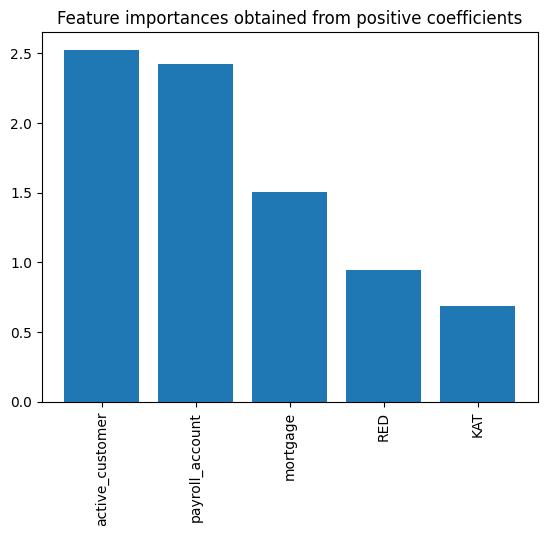

In [ ]:
#features with high positive coefficients
plt.bar(x=importances.head()['Attribute'], height=importances.head()['Importance'])
plt.title('Feature importances obtained from positive coefficients')
plt.xticks(rotation='vertical')
plt.show()

The most important feature with a positive correlation in this model is whether someone is an active customer

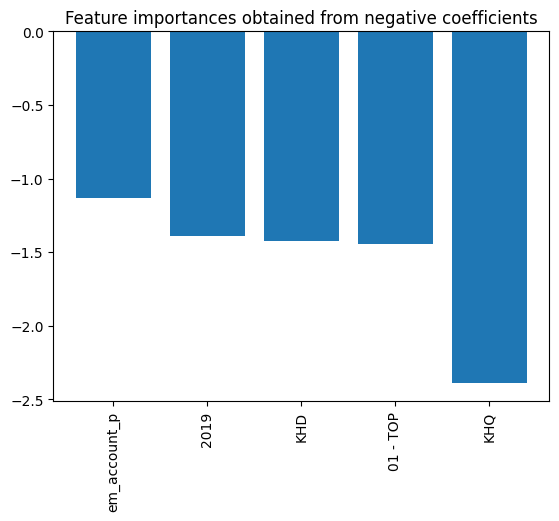

In [ ]:
#features with high negative coefficients
plt.bar(x=importances.tail()['Attribute'], height=importances.tail()['Importance'])
plt.title('Feature importances obtained from negative coefficients')
plt.xticks(rotation='vertical')
plt.show()

The most important feature with a negative correlation is whether or not someone belongs to acquisition channel KHQ

b) Predictions

In [ ]:
results_logr = results_eval(logr, train_X_scaled, train_y)
results_logr.head()

,fin_prod_by_cust,fin_prod_prediction,Success
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


c) Evaluation

In [ ]:
metr(results_logr, logr, test_X_scaled, test_y)

Confusion matrix:  [[1174490   18070]
 [ 122059   72571]]
TN = 1174490 - FP = 18070 - FN = 122059 - TP = 72571 

Train Accuracy:  0.898983556686539
Train Precision:  0.8006420935338313
Train Recall:  0.37286646457380673
Train F1 score: 0.5087863820717844
Test Accuracy:  0.9308276888208376


(0.5087863820717844, 0.9308276888208376)

The F1 score for this model is 50.88%, test accuracy is 93.08%

d) Optimization

The F1 score for this model is already higher than the one for the decision tree, so this model will be used for further optimization. The goal is to improve the F1 score and test accuracy. Since the target is unbalanced, the class weight will be adjusted so that more importance is given to fin_prod_by_cust=1. A grid search is performed with the validation set to find the best parameters based on the F1 score.

In [ ]:
# Define the scorer: based on F1 score
scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'class_weight': [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6},{0: 0.6,1:0.4}]
}

#search for best class weight based on F1 score
grid_search = GridSearchCV(estimator=logr, param_grid=param_grid, scoring=scorer)
grid_search.fit(val_X_scaled, val_y)

#print best class weight
best_params = grid_search.best_params_
print("Best class weight:", best_params)

#save model with best class weight and make predictions
logr2 = grid_search.best_estimator_

Best class weight: {'class_weight': {0: 0.6, 1: 0.4}}


In [ ]:
results_logr2 = results_eval(logr2, train_X_scaled, train_y)
results_logr2.head()

,fin_prod_by_cust,fin_prod_prediction,Success
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
f1_logr, test_accuracy_logr = metr(results_logr2, logr2, test_X_scaled, test_y)

Confusion matrix:  [[1135035   57525]
 [ 108407   86223]]
TN = 1135035 - FP = 57525 - FN = 108407 - TP = 86223 

Train Accuracy:  0.8803826440502022
Train Precision:  0.5998205192420069
Train Recall:  0.44300981349226737
Train F1 score: 0.5096253302519667
Test Accuracy:  0.928788311317572


The F1 score increased less than 1%, to 50.96%. The test accuracy went slightly down to 92.88%.

##### 4.3.3) XGBoost

a) Model building

In [ ]:
#instantiate model
xgb1 = xgb.XGBClassifier()

In [ ]:
#train model
xgb1.fit(train_X_scaled, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#get feature importances
importance_scores = xgb1.feature_importances_
feature_names = train_X_scaled.columns
feature_importances = dict(zip(feature_names, importance_scores))

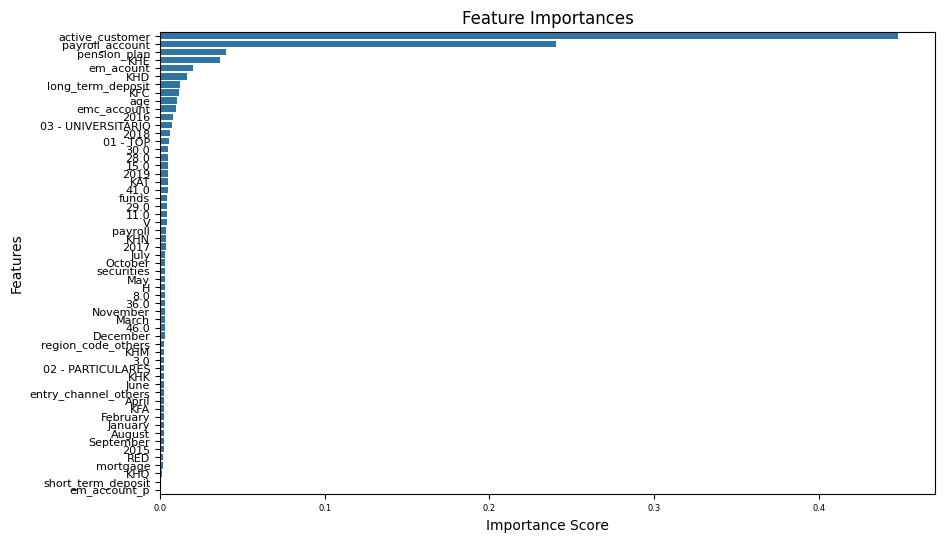

In [ ]:
# Sort the feature importances
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importance_scores = [x[1] for x in sorted_features]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance_scores, y=sorted_feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(fontsize=6)
plt.yticks(fontsize=8)
plt.show()

b) Predictions

In [ ]:
results_xgb = results_eval(xgb1, train_X_scaled, train_y)
results_xgb.head()

,fin_prod_by_cust,fin_prod_prediction,Success
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


c) Evaluation

In [ ]:
metr(results_xgb, xgb1, test_X_scaled, test_y)

Confusion matrix:  [[1169448   23112]
 [  96767   97863]]
TN = 1169448 - FP = 23112 - FN = 96767 - TP = 97863 

Train Accuracy:  0.9135814127841175
Train Precision:  0.8089522628642282
Train Recall:  0.5028155988285464
Train F1 score: 0.6201612775462999
Test Accuracy:  0.9317403264734124


(0.6201612775462999, 0.9317403264734124)

The F1 score of this XGBoost model is 62.01%. The test accuracy is 93.17%

d) Optimization

To optimize this model some grid search will be performed the optimal learning rate and number of estimators.

In [ ]:
param_grid2 = {
    'learning_rate': [0.3,0.4,0.5],
    'n_estimators': [100, 300, 500]
}

#search for best learning rate based on F1 score
grid_search = GridSearchCV(estimator=xgb1, param_grid=param_grid2, scoring=scorer)
grid_search.fit(val_X_scaled, val_y)

#print best parameters
best_params = grid_search.best_params_
print("Best paramters:", best_params)

#save model with best parameters and make predictions
xgb2 = grid_search.best_estimator_

Best paramters: {'learning_rate': 0.4, 'n_estimators': 100}


In [ ]:
results_xgb2 = results_eval(xgb2, train_X_scaled, train_y)
results_xgb2.head()

,fin_prod_by_cust,fin_prod_prediction,Success
0,0,0,1
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0


In [ ]:
f1_xgb, test_accuracy_xgb = metr(results_xgb2, xgb2, test_X_scaled, test_y)

Confusion matrix:  [[1129647   62913]
 [  98703   95927]]
TN = 1129647 - FP = 62913 - FN = 98703 - TP = 95927 

Train Accuracy:  0.8834939698238886
Train Precision:  0.6039221858473937
Train Recall:  0.4928685197554334
Train F1 score: 0.5427730783376241
Test Accuracy:  0.9277199629754582


By setting the learning rate to 0.4 and the number of estimators to 100 the F1 score went down to 54.28%, which could be a sign of overfitting in the previous model. The final test accuracy is 92.77%. Still, XGBoost model has the highest F1 score out of the three models and will therefore be used for the predictions:

In [ ]:
print("F1 score decision tree:", f1_tree.round(4)*100,"%")
print("Test accuracy decision tree:", test_accuracy_tree.round(4)*100,"%\n")

print("F1 score logistic regression:",f1_logr.round(4)*100,"%")
print("Test accuracy logistic regression:", test_accuracy_logr.round(4)*100,"%\n")

print("F1 score XGBoost:",f1_xgb.round(4)*100,"%")
print("Test accuracy XGBoost:", test_accuracy_xgb.round(4)*100,"%")

F1 score decision tree: 48.92 %
Test accuracy decision tree: 93.15 %

F1 score logistic regression: 50.96000000000001 %
Test accuracy logistic regression: 92.88 %

F1 score XGBoost: 54.279999999999994 %
Test accuracy XGBoost: 92.77 %


In [ ]:
#get feature importances
importance_scores = xgb2.feature_importances_
feature_names = train_X_scaled.columns
feature_importances = dict(zip(feature_names, importance_scores))

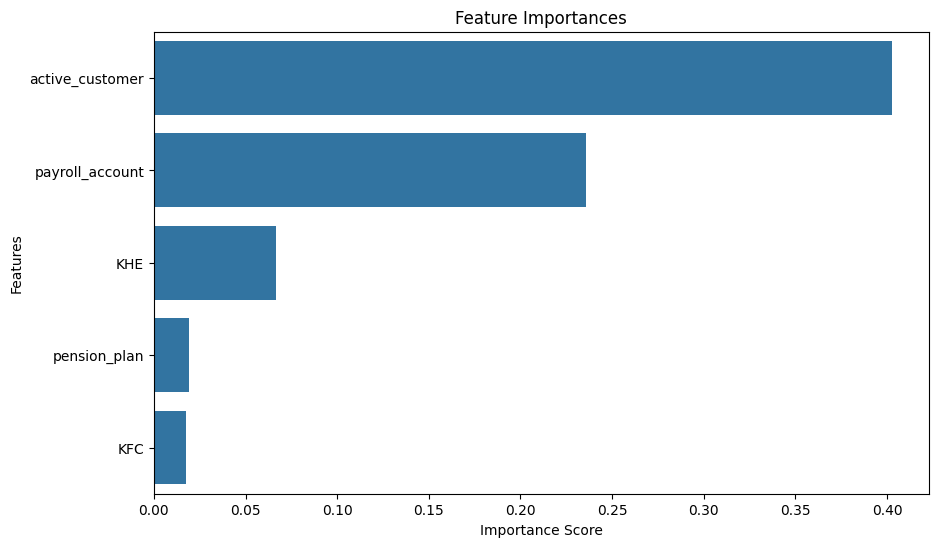

In [ ]:
# Sort the feature importances
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names = [x[0] for x in sorted_features]
sorted_importance_scores = [x[1] for x in sorted_features]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance_scores[:5], y=sorted_feature_names[:5])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The top5 features of this model are:
   
*   Whether or not someone is an active customer
*   Whether or not someone has an account awarded with a bonus due to payroll
*   Whether or not someone was acquired via entry channel KHE
*   Whether or not someone has a pension plan
*   Whether or not someone was acquired via entry channel KFC








#### 5) Build customer list

Filter selection set by target = 0 , as we need only those customers that the model has not been trained and have never hired financing products so far. If the model makes a positive prediction on those that means that they do share the same characteristics as those customers that do buy financial products.

In [ ]:
sel_set.head()

,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,fin_prod_by_cust,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,RED,entry_channel_others,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
2311982,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2311983,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2311984,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2311985,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2311986,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


Now we filter out all those customers that we now have never hired any financing products (not now, not in the past, not in the future). The target column needs to be dropped before making the predictions.

In [ ]:
sel_set2 = sel_set[sel_set['fin_prod_by_cust']==0]
sel_set2.drop(columns='fin_prod_by_cust',inplace=True)
sel_set2.shape

<ipython-input-295-5a14c91a5c53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_set2.drop(columns='fin_prod_by_cust',inplace=True)


(2042665, 57)

Now the predictions can be added to the dataframe.

In [ ]:
sel_set2['prediction'] = xgb2.predict(sel_set2)
sel_set2.head()

<ipython-input-296-adffc1ea6012>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_set2['prediction'] = xgb2.predict(sel_set2)


,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,RED,entry_channel_others,11.0,...,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019,prediction
2311982,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2311983,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2311984,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2311985,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2311986,0.0,0,0,0,0,0,0.0,0.0,0,0,0,1,0.27,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


Check how many positive predictions there are:

In [ ]:
print(sel_set2[sel_set2['prediction']==1].shape[0],"positive predictions")

130885 positive predictions


The indices of the positive predictions are saved so that we can find the corresponding 'pk_cid_x' in the original df (df7)

In [ ]:
positive_preds = sel_set2[sel_set2['prediction']==1].index.tolist()

Filter the original df, df7, by the customer IDs with positive predictions

In [ ]:
df7[df7.index.isin(positive_preds)]

,pk_cid_x,pk_partition_x,active_customer,short_term_deposit,mortgage,funds,securities,long_term_deposit,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,age,fin_prod_by_cust,KAT,KFA,KFC,KHD,KHE,KHK,KHM,KHN,KHQ,...,46.0,8.0,region_code_others,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,H,V,April,August,December,February,January,July,June,March,May,November,October,September,2015,2016,2017,2018,2019
2312085,1216580,2018-01-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,26,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2312086,1216580,2018-02-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,26,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2312087,1216580,2018-03-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,26,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2312088,1216580,2018-04-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,26,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2312089,1216580,2018-05-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,26,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623946,1553232,2019-05-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,41,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4623947,1553241,2019-05-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,52,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4623951,1553273,2019-05-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4623952,1553288,2019-05-28,1.0,0,0,0,0,0,0.0,0.0,0,0,0,1,38,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


Find unique customer IDs for which the positive predictions were identified

In [ ]:
df_unique = pd.DataFrame(df7[df7.index.isin(positive_preds)].groupby('pk_cid_x')['pk_partition_x'].count())
print(df_unique.shape[0],"unique customer IDs")

18881 unique customer IDs


Now we have 18,881 unique customer IDs that have never hired any financing products with positive predictions based on the model. The fact that the model makes positive predictions for those indicates that these customer IDs share the same characteristics as those customer IDs that the model was trained on and that did hire financing produts.

If we send the email to the first 10.000 of these customers we need to take into account several factors in order to predict the ROI.
1. Conversion rate
Let's assume three scenarios: 0.3%, 0.6% and 1%
2. Test accuracy of the model (92.77%)
3. Expected revenue (60€)

Expected revenue = Emails sent * CR * Model test accuracy * Revenue by product

In [ ]:
print("Expected revenue with a CR of 0.3%:", 10000*0.003*0.9277*60,"€")

Expected revenue with a CR of 0.3%: 1669.86 €


In [ ]:
print("Expected revenue with a CR of 0.6%:", 10000*0.006*0.9277*60,"€")

Expected revenue with a CR of 0.6%: 3339.72 €


In [ ]:
print("Expected revenue with a CR of 1%:", 10000*0.01*0.9277*60,"€")

Expected revenue with a CR of 1%: 5566.2 €


### 6. Save customer list for later use

In [ ]:
df_targets = df7.loc[df7.index.isin(positive_preds), 'pk_cid_x']
df_targets = df_targets.drop_duplicates(keep='last')
df_targets

2312101    1216580
2312135    1216582
2312302    1216600
2312717    1216639
2312882    1216650
            ...   
4623946    1553232
4623947    1553241
4623951    1553273
4623952    1553288
4623961    1553436
Name: pk_cid_x, Length: 18881, dtype: int64

In [ ]:
#save customer list for later use
df_targets.to_csv('/content/drive/MyDrive/easyMoney_data/data/targets.csv', index=False)